<a href="https://colab.research.google.com/github/HenriqueCF8896/MNCM/blob/main/Programa8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converged in 4550 iterations.


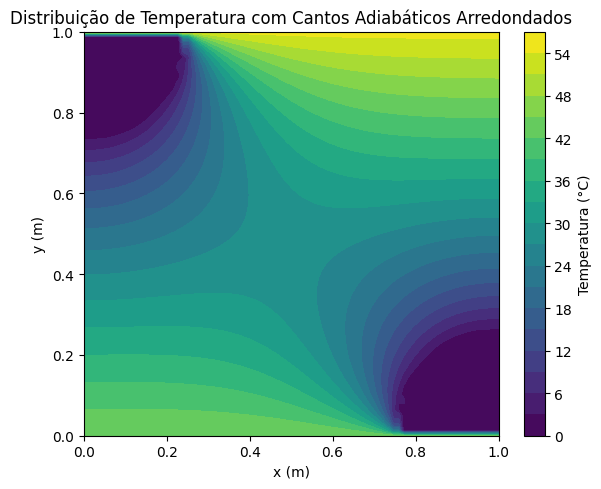

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da malha
nx, ny = 80, 80
Lx, Ly = 1.0, 1.0
dx, dy = Lx/(nx-1), Ly/(ny-1)
k = 413

# Condições de contorno
T_top = 55.0
T_bottom = 45.0
q_left = 250.0
q_right = 210.0

# Inicialização do campo de temperatura
T = np.zeros((ny, nx))

# Coordenadas da malha
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Máscara de domínio: remove cantos arredondados adiabáticos
radius = 0.25
mask = np.ones_like(T, dtype=bool)
mask &= ~((X - 0)**2 + (Y - Ly)**2 < radius**2)  # canto superior esquerdo
mask &= ~((X - Lx)**2 + (Y - 0)**2 < radius**2)  # canto inferior direito

# Aplica Dirichlet nas bordas horizontais
T[0, :] = T_bottom
T[-1, :] = T_top

# Parâmetros do método iterativo
omega = 1.4
tolerance = 1e-6
max_iter = 10000

# Iterações de Gauss-Seidel com SOR
for it in range(max_iter):
    T_old = T.copy()

    # Atualização dos nós internos válidos
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            if not mask[j, i]:
                continue
            T[j, i] = (1 - omega)*T[j, i] + omega*0.25*(
                T[j+1, i]*mask[j+1, i] + T[j-1, i]*mask[j-1, i] +
                T[j, i+1]*mask[j, i+1] + T[j, i-1]*mask[j, i-1]
            ) / (
                mask[j+1, i] + mask[j-1, i] + mask[j, i+1] + mask[j, i-1]
            )

    # Aplicação corrigida das condições de Neumann laterais apenas se ambos os pontos são válidos
    for j in range(ny):
        if mask[j, 0] and mask[j, 1]:
            T[j, 0] = T[j, 1] - dx * q_left / k
        if mask[j, -1] and mask[j, -2]:
            T[j, -1] = T[j, -2] + dx * q_right / k

    # Reforça Dirichlet nas bordas horizontais apenas onde permitido
    T[0, :] = np.where(mask[0, :], T_bottom, T[0, :])
    T[-1, :] = np.where(mask[-1, :], T_top, T[-1, :])

    # Espelhamento para bordas adiabáticas curvas
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            if not mask[j, i]:
                # tenta espelhar de um vizinho válido mais próximo
                for dj, di in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    if mask[j+dj, i+di]:
                        T[j, i] = T[j+dj, i+di]
                        break

    # Verifica convergência
    diff = np.max(np.abs(T - T_old))
    if diff < tolerance:
        print(f"Converged in {it} iterations.")
        break

# Plotando a nova distribuição de temperatura
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, T, levels=20, cmap='viridis')
plt.colorbar(cp, label='Temperatura (°C)')
plt.title('Distribuição de Temperatura com Cantos Adiabáticos Arredondados')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.tight_layout()
plt.show()
